请你编写代码对该股票未来3个月的变化进行预测（可以按照月来统计，也可以按照天）; 模型选择：ARMA/ARIMA/LSTM 中的任意一种

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMA
import statsmodels.api as sm
from itertools import product
import numpy as np

from datetime import datetime , timedelta

import warnings
warnings.filterwarnings('ignore')



In [2]:
# 数据加载
stock = pd.read_csv(r'E:\bi_course\L8\tue_course\002621.csv', encoding="gbk")

stock = stock[['日期','收盘价']]
stock.columns = ['date','price']
stock = stock.sort_values(by = 'date')
stock.head(5)
# stock.shape[0]


# 将时间作为stock的索引

stock.date = pd.to_datetime(stock.date)
stock.index = stock.date


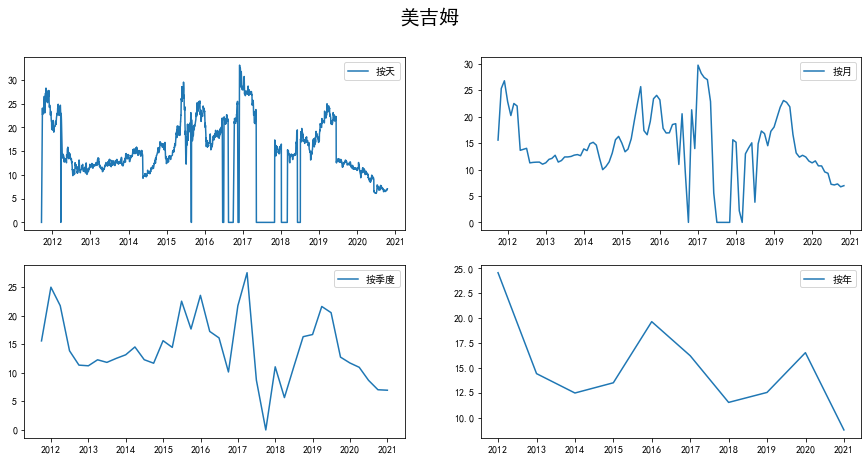

In [3]:
#转化成月, 季度和 年视图并绘制
stock_m = stock.resample('M').mean()
stock_q = stock.resample('Q-DEC').mean()
stock_y = stock.resample('A-DEC').mean() 

# print(stock_m)
# 绘图

fig = plt.figure(figsize=[15, 7])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.suptitle('美吉姆', fontsize=20)

plt.subplot(2,2,1)
plt.plot(stock.price, '-', label='按天')
plt.legend()

plt.subplot(2,2,2)
plt.plot(stock_m.price, '-', label='按月')
plt.legend()

plt.subplot(2,2,3)
plt.plot(stock_q.price, '-', label='按季度')
plt.legend()

plt.subplot(2,2,4)
plt.plot(stock_y.price, '-', label='按年')
plt.legend()
plt.show()


In [6]:
# 设置参数范围
ps = range(0, 5) #p阶数, 用于AR模型
qs = range(0, 5) #q阶数, 用于MA模型
ds = range(1, 2) #差分阶数, 用于ARIMA模型
param = product(ps, ds, qs) #ARIMA的三元组阶数
para_ls = list(param)

# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷

for p in para_ls:
    try:
        # model = ARIMA(stock_m.price, order=(p[0], p[1], p[2])).fit() 
        model = sm.tsa.statespace.SARIMAX(stock_m.price,
                                order=(p[0], p[1], p[2]),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()


    except ValueError:
        print('参数错误:', param)
        continue

aic = model.aic

#打擂主方式:
if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = p

results.append([p, model.aic])

# 输出最优模型
print('最优参数及AIC:', results)
print('最优模型: ', best_model.summary())


最优参数及AIC: [[(4, 1, 4), 633.5383050975227]]
最优模型:                                 SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  110
Model:               SARIMAX(4, 1, 4)   Log Likelihood                -307.769
Date:                Sun, 18 Oct 2020   AIC                            633.538
Time:                        20:26:17   BIC                            657.338
Sample:                    09-30-2011   HQIC                           643.180
                         - 10-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5759      0.746      0.772      0.440      -0.886       2.037
ar.L2         -0.6441      0.415     -1.551      0.121      -1.458       0.170
ar

In [7]:
# 添加未来要预测的3个月
future_day  = 90
start_date = stock.index[-1] + timedelta(days = 1)
end_date = start_date + timedelta(days = future_day)
date_ls = pd.date_range(start_date, end_date)
future = pd.DataFrame( index = date_ls, columns=stock_m.columns)


stock_predict = stock[['price']]
stock_predict = pd.concat([stock_predict, future]).resample('M').mean()

In [12]:
# get_prediction得到的是区间，使用predicted_mean
stock_predict['forecast'] = best_model.get_prediction(start= 0, end=len(stock_predict)).predicted_mean
# stock_predict['forecast'][0] = np.NaN #第一个预测不准确, 设置为NaN


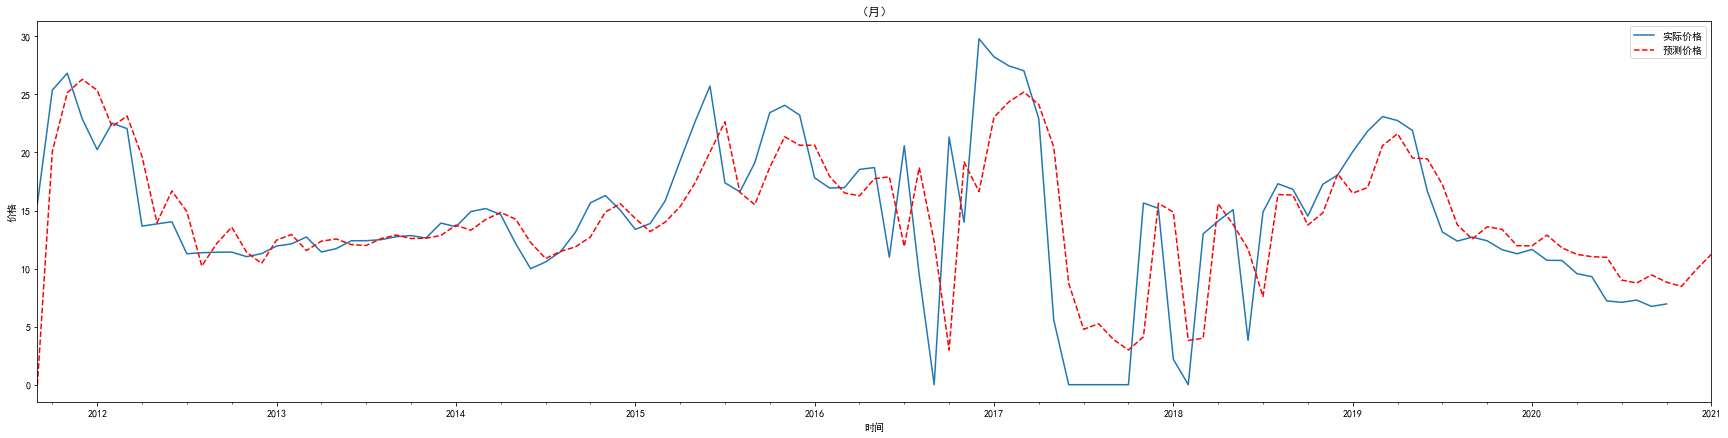

In [13]:
# 预测结果显示
plt.figure(figsize=(30,7))
stock_predict.price.plot(label='实际价格')
stock_predict.forecast.plot(color='r', ls='--', label='预测价格')
plt.legend()
plt.title('（月）')
plt.xlabel('时间')
plt.ylabel('价格')
plt.show()